# Exercise 06
# TensorFlow and Keras


---

 **Felipe Carvajal     Cod. 201728562

 **Nicolás Bernal      Cod. 201014697

In [7]:
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_moons

%matplotlib inline

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

### 1. Multilayer neural network in TensorFlow

You need to create a neural network model in TF that is able to discriminate the two classes in the following dataset:

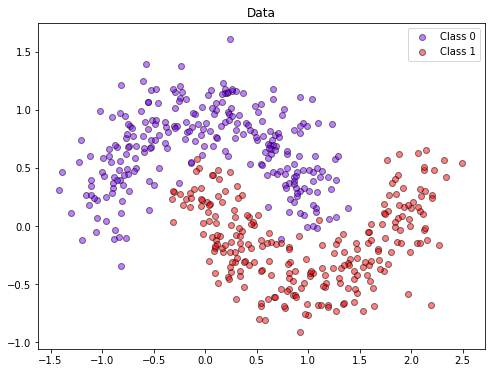

In [8]:
X, Y = make_moons(n_samples=1000, noise= 0.2, random_state=3)
x_train = X[:500]
x_test  = X[500:]
y_train = Y[:500]
y_test  = Y[500:]

pl.figure(figsize=(8, 6))
plot_data(x_train, y_train)

For this you will need to create a neural network with one hidden layer. You cannot use prebuilt models 
such as those in `tf.estimator`. **Hint**: extend the logistic regression example from the TensorFlow handout. 

Your answer must contain the following:
* A visualization of the CG of the model.
* A visualization of the decision region along with the test data.
* A snapshot from TensorBoard that shows the evolution of the training and test loss.

In [10]:
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline


# Helper functions to inline visualization of computing graphs
# Extracted from: 
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

In [11]:
numN = 10
graph = tf.Graph()
with graph.as_default():
    
    #DATOS ENTRADA:
    x = tf.placeholder(tf.float32,shape=[None,2]) 
    y_true = tf.placeholder(tf.float32,shape=None) 
    
    with tf.name_scope('hidden_layer') as scope: 
        
        #Capa1
        w_1 = tf.Variable(tf.random_normal([numN,2]),dtype=tf.float32,name='weights_1')
        b1 = tf.Variable(tf.random_normal([numN,1]),dtype=tf.float32,name='bias1') 
   
        #h = tf.matmul(w_1,tf.transpose(x)) + b1
        h = tf.sigmoid(tf.matmul(w_1,tf.transpose(x)) + b1, name='sigmoid') #brosfcasting
        print(w_1.shape)
        print(tf.transpose(x).shape)
        print(b1.shape)
        print(h.shape)
        
        #Capa2
        w_i = tf.Variable(tf.random_normal([numN,10]),dtype=tf.float32,name='weights_i')
        bi =tf.Variable(tf.random_normal([numN,1]), dtype=tf.float32,name='biasi')
   
        #h = tf.matmul(w_1,tf.transpose(x)) + b1
        hi = tf.sigmoid(tf.matmul(w_i,h) + bi, name='sigmoidi') #brosfcasting
        print(w_i.shape)
        print(h)
        print(bi.shape)
        print(hi.shape)
        
        #Capa3
        w_ii = tf.Variable(tf.random_normal([numN,10]),dtype=tf.float32,name='weights_ii')
        bii =tf.Variable(tf.random_normal([numN,1]), dtype=tf.float32,name='biasii')
   
        #h = tf.matmul(w_1,tf.transpose(x)) + b1
        hii = tf.sigmoid(tf.matmul(w_ii,hi) + bii, name='sigmoidii') #brosfcasting
        print(w_ii.shape)
        print(hi)
        print(bii.shape)
        print(hii.shape)
    
    #MODELO INFERENCIA 
    with tf.name_scope('inference') as scope:
        w_2 = tf.Variable(tf.random_normal([1,numN]),dtype=tf.float32,name='weights')
        b = tf.Variable(0,dtype=tf.float32,name='bias') 
        y_pred = tf.sigmoid(tf.matmul(w_2,hii) + b )
        print(w_2.shape)
        print(hi)
        print(b.shape)
        print(y_pred.shape)

    #FUNCION DE PERDIDA (SIGMOIDE)
    with tf.name_scope('loss') as scope:
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
        loss = tf.reduce_mean(loss) 
  
    #FUNCION ENTRENAMIENTO
    with tf.name_scope('train') as scope:
        learning_rate = 10
        optimizer = tf.train.GradientDescentOptimizer(learning_rate) 
        train = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    
show_graph(graph.as_graph_def())

(10, 2)
(2, ?)
(10, 1)
(10, ?)
(10, 10)
Tensor("hidden_layer/sigmoid:0", shape=(10, ?), dtype=float32)
(10, 1)
(10, ?)
(10, 10)
Tensor("hidden_layer/sigmoidi:0", shape=(10, ?), dtype=float32)
(10, 1)
(10, ?)
(1, 10)
Tensor("hidden_layer/sigmoidi:0", shape=(10, ?), dtype=float32)
()
(1, ?)


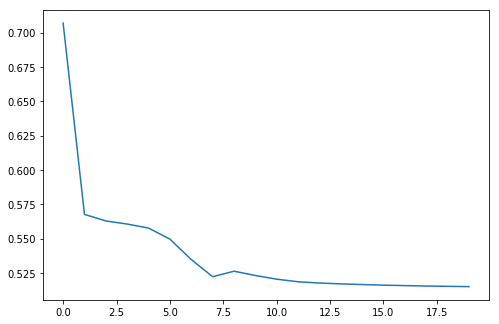

In [12]:
num_epochs = 1000
losses = []

with graph.as_default(): 
    sess = tf.Session()
    sess.run(init)      
    for step in range(num_epochs):
        sess.run(train,{x: x_train, y_true: y_train}) 
        if (step % 50 == 0):
            losses.append(sess.run(loss, {x: x_train, y_true: y_train})) 
                       
pl.figure(figsize = (8,16/3)) 
pl.plot(losses)

[[-1.0617591   0.3582702 ]
 [ 1.6128005  -0.30595145]
 [ 7.146445    4.189099  ]
 [ 1.4042834  -1.1774055 ]
 [-2.9260585   2.157219  ]
 [ 1.1831859  -1.1330628 ]
 [ 0.7447079  -0.64177185]
 [-1.0413269   0.0387757 ]
 [ 2.039846   -1.2803161 ]
 [-3.7278771   2.6994884 ]]
[[1.9654663e-05]]


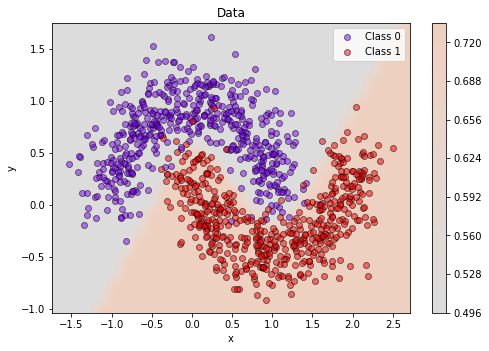

In [13]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

with graph.as_default():
    wval = sess.run(w_1)
    print(wval)
    result = sess.run(y_pred, {x:np.array([[1,2]])}) 
    print(result)
    def pred_fun(x1, x2):
        xval = np.array([[x1, x2]])
        return sigmoid(sess.run(y_pred,{x: xval}))

pl.figure(figsize = (8,16/3))    
plot_decision_region(X, pred_fun)
plot_data(X, Y)

### 2. Improving the Keras text classifier

Your goal is to improve the performance of the text classifier in the Keras handout. This is are the things that you need to try:

* Different activation functions for the hidden layer (https://keras.io/activations/)
* Different optimizers (https://keras.io/optimizers/)
* Add dropout between the hidden layer and the output layer (https://keras.io/layers/core/#dropout)
* Different initializers for the dense layers (https://keras.io/initializers/)

Try different combinations and report your findings at the end. Which configuration got the best accuracy in test?


Different activation functions for the hidden layer (https://keras.io/activations/)

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers

In [3]:
#Activation functions for the hidden layer (relu)
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [9]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# Fit the model
model.fit(x_train, y_train, epochs=50, batch_size=10)

Epoch 1/50
500/500 [==============================] - 0s 680us/step - loss: 0.5975 - acc: 0.8160
Epoch 2/50
500/500 [==============================] - 0s 96us/step - loss: 0.5292 - acc: 0.8300
Epoch 3/50
500/500 [==============================] - 0s 88us/step - loss: 0.4509 - acc: 0.8400
Epoch 4/50
500/500 [==============================] - 0s 90us/step - loss: 0.3846 - acc: 0.8420
Epoch 5/50
500/500 [==============================] - 0s 92us/step - loss: 0.3442 - acc: 0.8560
Epoch 6/50
500/500 [==============================] - 0s 100us/step - loss: 0.3185 - acc: 0.8620
Epoch 7/50
500/500 [==============================] - 0s 98us/step - loss: 0.2996 - acc: 0.8680
Epoch 8/50
500/500 [==============================] - 0s 98us/step - loss: 0.2857 - acc: 0.8740
Epoch 9/50
500/500 [==============================] - 0s 90us/step - loss: 0.2750 - acc: 0.8700
Epoch 10/50
500/500 [==============================] - 0s 94us/step - loss: 0.2662 - acc: 0.8780
Epoch 11/50
500/500 [================

In [11]:
model.predict(x_test)

array([[8.82257745e-02],
       [9.79849279e-01],
       [3.18102015e-04],
       [3.22480470e-01],
       [1.20186165e-01],
       [9.89507914e-01],
       [5.52965153e-04],
       [1.70781657e-01],
       [9.97043431e-01],
       [9.73904550e-01],
       [9.99327779e-01],
       [9.96784925e-01],
       [6.27563596e-02],
       [2.00130027e-02],
       [9.95626211e-01],
       [3.06356512e-02],
       [9.49593820e-03],
       [1.01437327e-03],
       [9.76938307e-01],
       [9.99623299e-01],
       [9.97485518e-01],
       [8.92670825e-04],
       [9.95098531e-01],
       [1.04235850e-01],
       [9.80995953e-01],
       [9.21135902e-01],
       [1.02922708e-01],
       [6.08279645e-01],
       [1.73282984e-03],
       [8.06540530e-03],
       [2.99096829e-03],
       [9.13757980e-01],
       [9.93868053e-01],
       [3.30205001e-02],
       [9.91714895e-01],
       [7.05534369e-02],
       [1.87978745e-02],
       [9.97834027e-01],
       [9.13347006e-01],
       [9.69301641e-01],


In [12]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

500/500 [==============================] - 0s 100us/step
Test score: 0.20395076152682304
Test accuracy: 0.924


In [14]:
#Activation functions for the hidden layer (tanh)
model = Sequential()
model.add(Dense(10, input_dim=2, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
# Fit the model
model.fit(x_train, y_train, epochs=50, batch_size=10)

Epoch 1/50
500/500 [==============================] - 0s 650us/step - loss: 0.8599 - acc: 0.3120
Epoch 2/50
500/500 [==============================] - 0s 104us/step - loss: 0.5912 - acc: 0.7700
Epoch 3/50
500/500 [==============================] - 0s 100us/step - loss: 0.4413 - acc: 0.8600
Epoch 4/50
500/500 [==============================] - 0s 96us/step - loss: 0.3696 - acc: 0.8460
Epoch 5/50
500/500 [==============================] - 0s 92us/step - loss: 0.3321 - acc: 0.8520
Epoch 6/50
500/500 [==============================] - 0s 96us/step - loss: 0.3098 - acc: 0.8620
Epoch 7/50
500/500 [==============================] - 0s 96us/step - loss: 0.2955 - acc: 0.8760
Epoch 8/50
500/500 [==============================] - 0s 116us/step - loss: 0.2845 - acc: 0.8760
Epoch 9/50
500/500 [==============================] - 0s 112us/step - loss: 0.2769 - acc: 0.8760
Epoch 10/50
500/500 [==============================] - 0s 96us/step - loss: 0.2721 - acc: 0.8740
Epoch 11/50
500/500 [=============

In [17]:
model.predict(x_test)

array([[0.10217017],
       [0.96029127],
       [0.00259791],
       [0.39077637],
       [0.17048228],
       [0.974033  ],
       [0.01291233],
       [0.05951421],
       [0.98302656],
       [0.94800466],
       [0.9946641 ],
       [0.9910013 ],
       [0.03079965],
       [0.01677448],
       [0.9801793 ],
       [0.02729996],
       [0.0119413 ],
       [0.02140894],
       [0.9552829 ],
       [0.99284863],
       [0.99074477],
       [0.02225671],
       [0.97798216],
       [0.15493646],
       [0.96200603],
       [0.9026349 ],
       [0.06412665],
       [0.6396465 ],
       [0.00602425],
       [0.0145656 ],
       [0.13906324],
       [0.84005517],
       [0.9810013 ],
       [0.02282469],
       [0.982488  ],
       [0.41760373],
       [0.01580409],
       [0.9843911 ],
       [0.6247446 ],
       [0.95137316],
       [0.45800936],
       [0.9089833 ],
       [0.0101048 ],
       [0.07457308],
       [0.07295893],
       [0.954061  ],
       [0.08462292],
       [0.673

In [18]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

500/500 [==============================] - 0s 126us/step
Test score: 0.25553466099500655
Test accuracy: 0.898


Comparando los dos modelos, teniendo en cuenta dos capas densas de 10 neuronas, una con activación relu y otra con activación tanh, dado el accuracy, la activación relu dió un mejor resultado por el mayor accuracy (0.924)

Different optimizers (https://keras.io/optimizers/)

In [19]:
#Different optimizers (adam)
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(x_train, y_train, epochs=50, batch_size=10)

model.predict(x_test)

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
500/500 [==============================] - 0s 690us/step - loss: 0.7032 - acc: 0.5700
Epoch 2/50
500/500 [==============================] - 0s 112us/step - loss: 0.6507 - acc: 0.7360
Epoch 3/50
500/500 [==============================] - 0s 112us/step - loss: 0.5872 - acc: 0.8520
Epoch 4/50
500/500 [==============================] - 0s 102us/step - loss: 0.4912 - acc: 0.8660
Epoch 5/50
500/500 [==============================] - 0s 112us/step - loss: 0.3972 - acc: 0.8640
Epoch 6/50
500/500 [==============================] - ETA: 0s - loss: 0.3305 - acc: 0.866 - 0s 114us/step - loss: 0.3323 - acc: 0.8640
Epoch 7/50
500/500 [==============================] - 0s 116us/step - loss: 0.2943 - acc: 0.8760
Epoch 8/50
500/500 [==============================] - 0s 112us/step - loss: 0.2734 - acc: 0.8780
Epoch 9/50
500/500 [==============================] - 0s 102us/step - loss: 0.2607 - acc: 0.8780
Epoch 10/50
500/500 [==============================] - 0s 116us/step - loss: 0.2538 - acc

In [22]:
#Different optimizers (SGD)
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.1, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Fit the model
model.fit(x_train, y_train, epochs=50, batch_size=10)

model.predict(x_test)

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
500/500 [==============================] - 0s 616us/step - loss: 0.6168 - acc: 0.5440
Epoch 2/50
500/500 [==============================] - 0s 94us/step - loss: 0.5885 - acc: 0.6460
Epoch 3/50
500/500 [==============================] - 0s 96us/step - loss: 0.5666 - acc: 0.8020
Epoch 4/50
500/500 [==============================] - 0s 98us/step - loss: 0.5469 - acc: 0.8260
Epoch 5/50
500/500 [==============================] - 0s 96us/step - loss: 0.5283 - acc: 0.8400
Epoch 6/50
500/500 [==============================] - 0s 94us/step - loss: 0.5107 - acc: 0.8560
Epoch 7/50
500/500 [==============================] - 0s 96us/step - loss: 0.4941 - acc: 0.8600
Epoch 8/50
500/500 [==============================] - 0s 92us/step - loss: 0.4786 - acc: 0.8680
Epoch 9/50
500/500 [==============================] - 0s 104us/step - loss: 0.4639 - acc: 0.8620
Epoch 10/50
500/500 [==============================] - 0s 100us/step - loss: 0.4501 - acc: 0.8620
Epoch 11/50
500/500 [===============

Comparando los dos modelos, teniendo en cuenta dos capas densas de 10 neuronas, una con optimizador adam y otra con optimizador SGD, dado el accuracy, el optimizador adam dió un mejor resultado por el mayor accuracy (0.91)

Add dropout between the hidden layer and the output layer (https://keras.io/layers/core/#dropout)

In [23]:
#Dropout (0.5)
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(x_train, y_train, epochs=50, batch_size=10)

model.predict(x_test)

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
500/500 [==============================] - 1s 1ms/step - loss: 0.6757 - acc: 0.4920
Epoch 2/50
500/500 [==============================] - 0s 116us/step - loss: 0.6046 - acc: 0.5800
Epoch 3/50
500/500 [==============================] - 0s 120us/step - loss: 0.5751 - acc: 0.7160
Epoch 4/50
500/500 [==============================] - 0s 124us/step - loss: 0.5388 - acc: 0.7640
Epoch 5/50
500/500 [==============================] - 0s 124us/step - loss: 0.4997 - acc: 0.7980
Epoch 6/50
500/500 [==============================] - 0s 124us/step - loss: 0.4633 - acc: 0.8260
Epoch 7/50
500/500 [==============================] - 0s 126us/step - loss: 0.4447 - acc: 0.8420
Epoch 8/50
500/500 [==============================] - 0s 122us/step - loss: 0.4150 - acc: 0.8400
Epoch 9/50
500/500 [==============================] - 0s 120us/step - loss: 0.4043 - acc: 0.8360
Epoch 10/50
500/500 [==============================] - 0s 124us/step - loss: 0.3464 - acc: 0.8760
Epoch 11/50
500/500 [==========

In [24]:
#Dropout (0.9)
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.9))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(x_train, y_train, epochs=50, batch_size=10)

model.predict(x_test)

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
500/500 [==============================] - 0s 853us/step - loss: 0.8283 - acc: 0.4700
Epoch 2/50
500/500 [==============================] - 0s 104us/step - loss: 0.7212 - acc: 0.5240
Epoch 3/50
500/500 [==============================] - 0s 118us/step - loss: 0.6892 - acc: 0.5160
Epoch 4/50
500/500 [==============================] - 0s 126us/step - loss: 0.6575 - acc: 0.5280
Epoch 5/50
500/500 [==============================] - 0s 126us/step - loss: 0.6430 - acc: 0.5400
Epoch 6/50
500/500 [==============================] - 0s 120us/step - loss: 0.6371 - acc: 0.5480
Epoch 7/50
500/500 [==============================] - 0s 116us/step - loss: 0.6396 - acc: 0.5440
Epoch 8/50
500/500 [==============================] - 0s 116us/step - loss: 0.6255 - acc: 0.5520
Epoch 9/50
500/500 [==============================] - 0s 116us/step - loss: 0.6209 - acc: 0.5420
Epoch 10/50
500/500 [==============================] - 0s 116us/step - loss: 0.6119 - acc: 0.5780
Epoch 11/50
500/500 [========

Comparando los dos modelos, teniendo en cuenta dos capas densas de 10 neuronas, una con Dropout de 0.5 y otra con Dropout 0.9, dado el accuracy, el Dropout de 0.5 dió un mejor resultado por el mayor accuracy (0.91)

Different initializers for the dense layers (https://keras.io/initializers/)

In [25]:
#Different initializers (kernel_initializer='random_uniform',bias_initializer='zeros')
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu',kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(x_train, y_train, epochs=50, batch_size=10)

model.predict(x_test)

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
500/500 [==============================] - 1s 1ms/step - loss: 0.6867 - acc: 0.5560
Epoch 2/50
500/500 [==============================] - 0s 114us/step - loss: 0.6604 - acc: 0.7520
Epoch 3/50
500/500 [==============================] - 0s 122us/step - loss: 0.6078 - acc: 0.8000
Epoch 4/50
500/500 [==============================] - 0s 120us/step - loss: 0.5386 - acc: 0.7840
Epoch 5/50
500/500 [==============================] - 0s 128us/step - loss: 0.4666 - acc: 0.7940
Epoch 6/50
500/500 [==============================] - 0s 128us/step - loss: 0.4107 - acc: 0.8440
Epoch 7/50
500/500 [==============================] - 0s 120us/step - loss: 0.4059 - acc: 0.8140
Epoch 8/50
500/500 [==============================] - 0s 122us/step - loss: 0.3738 - acc: 0.8180
Epoch 9/50
500/500 [==============================] - 0s 126us/step - loss: 0.3839 - acc: 0.8400
Epoch 10/50
500/500 [==============================] - 0s 128us/step - loss: 0.3755 - acc: 0.8300
Epoch 11/50
500/500 [==========

In [27]:
#Different initializers (kernel_initializer='random_uniform',bias_initializer='zeros')
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu',kernel_initializer='random_normal'))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(x_train, y_train, epochs=50, batch_size=10)

model.predict(x_test)

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
500/500 [==============================] - 1s 1ms/step - loss: 0.6840 - acc: 0.6820
Epoch 2/50
500/500 [==============================] - 0s 142us/step - loss: 0.6512 - acc: 0.7940
Epoch 3/50
500/500 [==============================] - 0s 134us/step - loss: 0.5997 - acc: 0.7980
Epoch 4/50
500/500 [==============================] - 0s 124us/step - loss: 0.5284 - acc: 0.7920
Epoch 5/50
500/500 [==============================] - 0s 128us/step - loss: 0.4486 - acc: 0.8400
Epoch 6/50
500/500 [==============================] - 0s 118us/step - loss: 0.4021 - acc: 0.8600
Epoch 7/50
500/500 [==============================] - 0s 128us/step - loss: 0.3942 - acc: 0.8520
Epoch 8/50
500/500 [==============================] - 0s 128us/step - loss: 0.3833 - acc: 0.8660
Epoch 9/50
500/500 [==============================] - 0s 128us/step - loss: 0.3580 - acc: 0.8500
Epoch 10/50
500/500 [==============================] - 0s 126us/step - loss: 0.3434 - acc: 0.8620
Epoch 11/50
500/500 [==========

Comparando los dos modelos, teniendo en cuenta dos capas densas de 10 neuronas, una con Inicializador kernel_initializer='random_uniform',bias_initializer='zeros' y otra con Inicializador kernel_initializer='random_normal', dado el accuracy, el inicializador no realizó mayor contribución a la precisión de la predicción.